# **Beta-Weighted Stock Portfolio**
**Introduction** <br>
A beta-weighted stock portfolio evaluates the risk relative to the market by considering each stock's beta. Beta measures a stock's volatility in relation to the market. A beta of 1 indicates that the stock moves with the market. A beta greater than 1 indicates higher volatility than the market, while a beta less than 1 indicates lower volatility.

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats
import yfinance as yf

In [2]:
start = dt.datetime(2021, 1, 1)
end = dt.datetime.now()
stocklist=['SBIN', 'ICICIBANK', 'HDFCBANK', 'AXISBANK', 'RELIANCE']
stocks = ['^NSEI']+[i+'.NS' for i in stocklist]

In [3]:
df = yf.download(stocks, start, end)
log_returns = np.log(df.Close / df.Close.shift(1)).dropna()
log_returns.head()

[*********************100%%**********************]  6 of 6 completed


Ticker,AXISBANK.NS,HDFCBANK.NS,ICICIBANK.NS,RELIANCE.NS,SBIN.NS,^NSEI
Date,,,,,,
2021-01-04,0.001442,-0.006371,0.007931,0.001684,0.005888,0.008128
2021-01-05,0.061688,0.007528,0.010384,-0.012510,0.002488,0.004701
2021-01-06,-0.015470,-0.004320,0.017437,-0.026726,0.011644,-0.003757
2021-01-07,0.025429,-0.003032,-0.010296,-0.001621,0.009254,-0.000629
2021-01-08,0.002381,0.010815,0.001754,0.011730,-0.005927,0.014738


In [4]:
def calc_beta(df):
    np_array = df.values
    # Market index is the first column 0
    m = np_array[:,0]
    beta = []
    for ind, col in enumerate(df):
        if ind > 0:
            # stock returns are indexed by ind
            s = np_array[:,ind]
            # Calculate covariance matrix between stock and market
            covariance = np.cov(s,m)
            beta.append( covariance[0,1]/covariance[1,1] )
    return pd.Series(beta, df.columns[1:], name='Beta')

In [5]:
calc_beta(log_returns)

Ticker
HDFCBANK.NS     0.359201
ICICIBANK.NS    0.575593
RELIANCE.NS     0.311406
SBIN.NS         0.585969
^NSEI           0.333082
Name: Beta, dtype: float64

In [6]:
#Linear regression
def regression_beta(df):
    np_array = df.values
    # Market index is the first column 0
    m = np_array[:,0]
    beta = []
    for ind, col in enumerate(df):
        if ind > 0:
            s = np_array[:,ind] # stock returns are column one from numpy array
            beta.append( stats.linregress(m,s)[0] )
    return pd.Series(beta, df.columns[1:], name='Beta')

In [7]:
regression_beta(log_returns)

Ticker
HDFCBANK.NS     0.359201
ICICIBANK.NS    0.575593
RELIANCE.NS     0.311406
SBIN.NS         0.585969
^NSEI           0.333082
Name: Beta, dtype: float64

In [8]:
def matrix_beta(df):
    # Market index is the first column 0
    X = df.values[:, [0]]
    # add an additional column for the intercept (initalise as 1's)
    X = np.concatenate([np.ones_like(X), X], axis=1)
    # Apply matrix algebra for linear regression model
    beta = np.linalg.pinv(X.T @ X) @ X.T @ df.values[:, 1:]
    return pd.Series(beta[1], df.columns[1:], name='Beta')

beta = matrix_beta(log_returns)
beta

Ticker
HDFCBANK.NS     0.359201
ICICIBANK.NS    0.575593
RELIANCE.NS     0.311406
SBIN.NS         0.585969
^NSEI           0.333082
Name: Beta, dtype: float64

In [9]:
units = np.array([100, 250, 300, 400, 200])
ASXprices = df.Close[-1:].values.tolist()[0]
price = np.array([round(price,2) for price in ASXprices[1:]])
value = [unit*pr for unit, pr in zip(units, price)]
weight = [round(val/sum(value),2) for val in value]
beta = round(beta,2)

In [10]:
Portfolio = pd.DataFrame({
    'Stock': stocklist,
    'Direction': 'Long',
    'Type': 'S',
    'Stock Price': price,
    'Price': price,
    'Units': units,
    'Value': units*price,
    'Weight': weight,
    'Beta': beta,
    'Weighted Beta': weight*beta
})
Portfolio

,Stock,Direction,Type,Stock Price,Price,Units,Value,Weight,Beta,Weighted Beta
Ticker,,,,,,,,,,
HDFCBANK.NS,SBIN,Long,S,1531.55,1531.55,100,153155.0,0.02,0.36,0.0072
ICICIBANK.NS,ICICIBANK,Long,S,1121.05,1121.05,250,280262.5,0.05,0.58,0.0290
RELIANCE.NS,HDFCBANK,Long,S,2860.80,2860.80,300,858240.0,0.14,0.31,0.0434
SBIN.NS,AXISBANK,Long,S,830.35,830.35,400,332140.0,0.05,0.59,0.0295
^NSEI,RELIANCE,Long,S,22530.70,22530.70,200,4506140.0,0.74,0.33,0.2442


In [11]:
Portfolio = Portfolio.drop(['Weight', 'Weighted Beta'], axis=1)
Portfolio['Delta'] = Portfolio['Units']
Portfolio

,Stock,Direction,Type,Stock Price,Price,Units,Value,Beta,Delta
Ticker,,,,,,,,,
HDFCBANK.NS,SBIN,Long,S,1531.55,1531.55,100,153155.0,0.36,100
ICICIBANK.NS,ICICIBANK,Long,S,1121.05,1121.05,250,280262.5,0.58,250
RELIANCE.NS,HDFCBANK,Long,S,2860.80,2860.80,300,858240.0,0.31,300
SBIN.NS,AXISBANK,Long,S,830.35,830.35,400,332140.0,0.59,400
^NSEI,RELIANCE,Long,S,22530.70,22530.70,200,4506140.0,0.33,200


In [12]:
#add options
Options = [
    {'option': 'SBIN0Z8', 'underlying': 'SBIN', 'price': 3.950, 'units': 2, 'delta': 0.627, 'direction': 'Short', 'type': 'Call'},
    {'option': 'RELIANCEQB9', 'underlying': 'RELIANCE', 'price': 1.325, 'units': 2, 'delta': -0.425, 'direction': 'Long', 'type': 'Put'}
]
for index, row in enumerate(Options):
    Portfolio.loc[row['option']] = [row['underlying'], row['direction'], row['type'], Portfolio.loc[row['underlying']+'.NS', 'Price'],
                                    row['price'], row['units'], row['price']*row['units']*100, beta[row['underlying']+'.NS'],
                                    (row['delta']*row['units']* 100 if row['direction'] == 'Long' else -row['delta']*row['units']*100)]
Portfolio

,Stock,Direction,Type,Stock Price,Price,Units,Value,Beta,Delta
Ticker,,,,,,,,,
HDFCBANK.NS,SBIN,Long,S,1531.55,1531.550,100,153155.0,0.36,100.0
ICICIBANK.NS,ICICIBANK,Long,S,1121.05,1121.050,250,280262.5,0.58,250.0
RELIANCE.NS,HDFCBANK,Long,S,2860.80,2860.800,300,858240.0,0.31,300.0
SBIN.NS,AXISBANK,Long,S,830.35,830.350,400,332140.0,0.59,400.0
^NSEI,RELIANCE,Long,S,22530.70,22530.700,200,4506140.0,0.33,200.0
SBIN0Z8,SBIN,Short,Call,830.35,3.950,2,790.0,0.59,-125.4
RELIANCEQB9,RELIANCE,Long,Put,2860.80,1.325,2,265.0,0.31,-85.0


In [13]:
Portfolio['ASX200 Weighted Delta (point)'] = round(Portfolio['Beta'] * (Portfolio['Stock Price']/ASXprices[0]) * Portfolio['Delta'],2)
Portfolio['ASX200 Weighted Delta (1%)'] = round(Portfolio['Beta'] * (Portfolio['Stock Price']) * Portfolio['Delta'] * 0.01,2)
Portfolio

,Stock,Direction,Type,Stock Price,Price,Units,Value,Beta,Delta,ASX200 Weighted Delta (point),ASX200 Weighted Delta (1%)
Ticker,,,,,,,,,,,
HDFCBANK.NS,SBIN,Long,S,1531.55,1531.550,100,153155.0,0.36,100.0,47.44,551.36
ICICIBANK.NS,ICICIBANK,Long,S,1121.05,1121.050,250,280262.5,0.58,250.0,139.87,1625.52
RELIANCE.NS,HDFCBANK,Long,S,2860.80,2860.800,300,858240.0,0.31,300.0,228.93,2660.54
SBIN.NS,AXISBANK,Long,S,830.35,830.350,400,332140.0,0.59,400.0,168.62,1959.63
^NSEI,RELIANCE,Long,S,22530.70,22530.700,200,4506140.0,0.33,200.0,1279.55,14870.26
SBIN0Z8,SBIN,Short,Call,830.35,3.950,2,790.0,0.59,-125.4,-52.86,-614.34
RELIANCEQB9,RELIANCE,Long,Put,2860.80,1.325,2,265.0,0.31,-85.0,-64.86,-753.82


In [14]:
Portfolio.loc['Total', ['Value', 'ASX200 Weighted Delta (point)', 'ASX200 Weighted Delta (1%)']] \
= Portfolio[['Value','ASX200 Weighted Delta (point)', 'ASX200 Weighted Delta (1%)']].sum()
Portfolio

,Stock,Direction,Type,Stock Price,Price,Units,Value,Beta,Delta,ASX200 Weighted Delta (point),ASX200 Weighted Delta (1%)
Ticker,,,,,,,,,,,
HDFCBANK.NS,SBIN,Long,S,1531.55,1531.550,100.0,153155.0,0.36,100.0,47.44,551.36
ICICIBANK.NS,ICICIBANK,Long,S,1121.05,1121.050,250.0,280262.5,0.58,250.0,139.87,1625.52
RELIANCE.NS,HDFCBANK,Long,S,2860.80,2860.800,300.0,858240.0,0.31,300.0,228.93,2660.54
SBIN.NS,AXISBANK,Long,S,830.35,830.350,400.0,332140.0,0.59,400.0,168.62,1959.63
^NSEI,RELIANCE,Long,S,22530.70,22530.700,200.0,4506140.0,0.33,200.0,1279.55,14870.26
SBIN0Z8,SBIN,Short,Call,830.35,3.950,2.0,790.0,0.59,-125.4,-52.86,-614.34
RELIANCEQB9,RELIANCE,Long,Put,2860.80,1.325,2.0,265.0,0.31,-85.0,-64.86,-753.82
Total,NaN,NaN,NaN,NaN,NaN,NaN,6130992.5,NaN,NaN,1746.69,20299.15


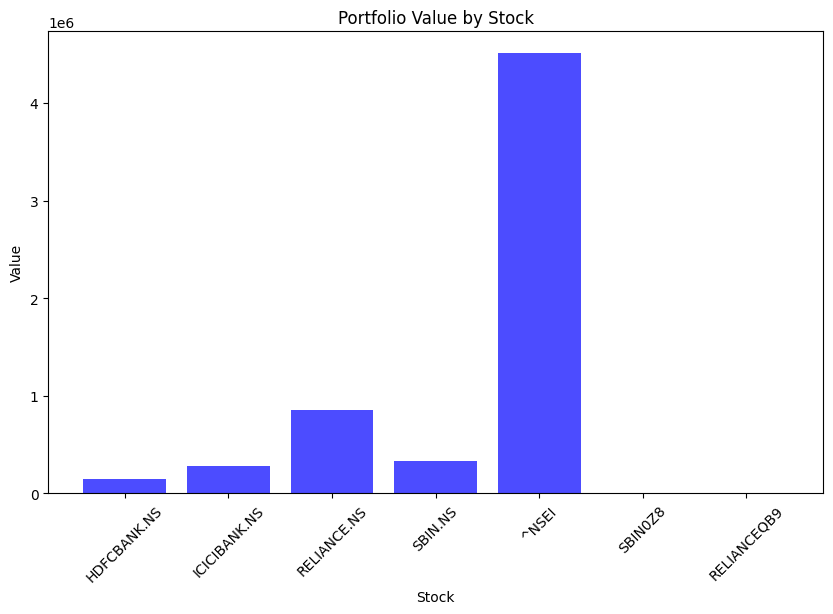

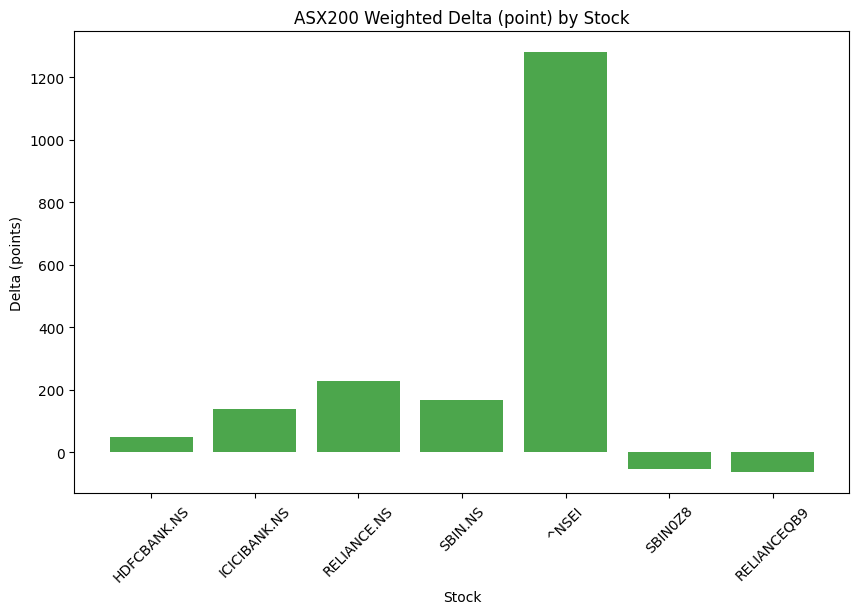

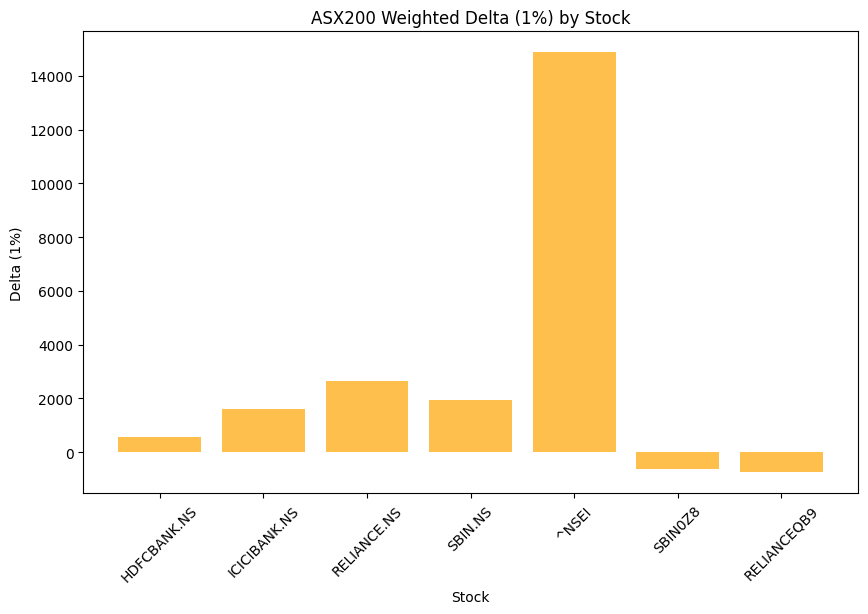

In [15]:
import matplotlib.pyplot as plt

# Plotting portfolio value
plt.figure(figsize=(10, 6))
plt.bar(Portfolio.index[:-1], Portfolio['Value'][:-1], color='blue', alpha=0.7)
plt.title('Portfolio Value by Stock')
plt.xlabel('Stock')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

# Plotting ASX200 weighted delta
plt.figure(figsize=(10, 6))
plt.bar(Portfolio.index[:-1], Portfolio['ASX200 Weighted Delta (point)'][:-1], color='green', alpha=0.7)
plt.title('ASX200 Weighted Delta (point) by Stock')
plt.xlabel('Stock')
plt.ylabel('Delta (points)')
plt.xticks(rotation=45)
plt.show()

# Plotting ASX200 weighted delta as a percentage
plt.figure(figsize=(10, 6))
plt.bar(Portfolio.index[:-1], Portfolio['ASX200 Weighted Delta (1%)'][:-1], color='orange', alpha=0.7)
plt.title('ASX200 Weighted Delta (1%) by Stock')
plt.xlabel('Stock')
plt.ylabel('Delta (1%)')
plt.xticks(rotation=45)
plt.show()
